In [1]:
import enum
from abc import ABCMeta, abstractmethod, abstractproperty

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

# Байесовские бандиты

Здесь мы реализуем несколько исследовательских стратегий для простейшей задачи - бандитов с распределением Бернулли.

У бандитов есть $K$ действий. Действие приводит к вознаграждению $r=1$ с вероятностью $0 \le \theta_k \le 1$, неизвестной агенту, но фиксированной во времени. Цель агента - минимизировать неоптимальность на фиксированном горизонте из $T$ действий:

$$\rho = T\theta^* - \sum_{t=1}^T r_t,$$

где $\theta^* = \max_k\{\theta_k\}$.

**Аналогия из жизни** - клинические испытания: у нас есть $k$ лекарств и $T$ больных. После приема лекарства пациент выздоравливает с вероятностью $\theta_k$. Задача найти наиболее эффективное лекарство.

Исследование по теме клинических испытаний - https://arxiv.org/pdf/1507.08025.pdf.

### Домашнее задание

Является взаимодополняющим с заданием по обучению с подкреплением, в сумме достаточно набрать 10 баллов.

Реализовать все нереализованные агенты:

1. [1 балл] $\varepsilon$-greedy
2. [1 балл] UCB
3. [1 балл] Thompson sampling
4. [2 балла] Своя стратегия
5. [2 балла] $\varepsilon$-greedy для riverflow
6. [3 балла] PSRL агент для riverflow

In [2]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.random.random() > self._probs[action]:
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """

In [3]:
class AbstractAgent(metaclass=ABCMeta):   
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):    
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Epsilon-greedy агент

> **for** $t = 1,2,...$ **do**

>> **for** $k = 1,...,K$ **do**

>>> $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \varepsilon$ or random action with probability $\varepsilon$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Реализуйте алгоритм, приведенный выше, далее:

In [8]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon = 0.01):
        self._epsilon = epsilon

    def get_action(self):
        ... # YOUR CODE GOES HERE
        
    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon) 

### UCB агент
У стратегии Epsilon-greedy нет предпочтений при случайном выборе действий. Вероятно было бы лучше выбирать среди действий те, насчет которых мы не уверены, но у них есть потенциал стать в итоге оптимальными. Можно придумать такой показатель для каждого действия, который отвечает и за оптимальность, и за неуверенность одновременно. Один из способов реализации такого показателя это алгоритм UCB1:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

>> **end for** 

>> $x_t \leftarrow argmax_{k}w$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Другие версии и анализ оптимальности - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf.

In [10]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        ... # YOUR CODE GOES HERE

### Thompson sampling

Алгоритм UCB1 не учитывает реальное распределение вознаграждений. Если таковое нам известно, то алгоритм можно значительно улучшить с помощью Thompson sampling'а.

Полагаем, что параметры $\theta_k$ независимо распределены одинаковым образом. В качестве априорных распределений возьмем beta-распределение с параметрами $\alpha=(\alpha_1, \dots, \alpha_k)$ и $\beta=(\beta_1, \dots, \beta_k)$. Т.е. для каждого параметра $\theta_k$ априорная функция вероятности выглядит как
$$
p(\theta_k) =
\frac{\Gamma(\alpha_k + \beta_k)}{\Gamma(\alpha_k) + \Gamma(\beta_k)}
\theta_k^{\alpha_k - 1}(1 - \theta_k)^{\beta_k - 1}
$$
При появлении новых наблюдений распределение обновляется по правилу Байеса.

С Бета-распределением удобно работать из-за свойств сопряженности - апостериорное распределение на действия тоже будет бета-распределением, и его параметры можно будет обновлять очень просто:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**
 

Домашнее чтение: https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf.

In [12]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        ... # YOUR CODE GOES HERE

In [93]:
def plot_regret(env, agents, n_steps=5000, n_trials=50):
    scores = {
        agent.name : [0.0 for step in range(n_steps)] for agent in agents
    }

    for trial in range(n_trials):
        env.reset()
        
        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()
            
            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward
                
            env.step()  # change bandit's state if it is unstationary

    plt.figure(figsize=(17, 8))
    for agent in agents:
        plt.plot(np.cumsum(scores[agent.name]) / n_trials)

    plt.legend([agent.name for agent in agents])
    
    plt.ylabel("regret")
    plt.xlabel("steps")
    
    plt.show()

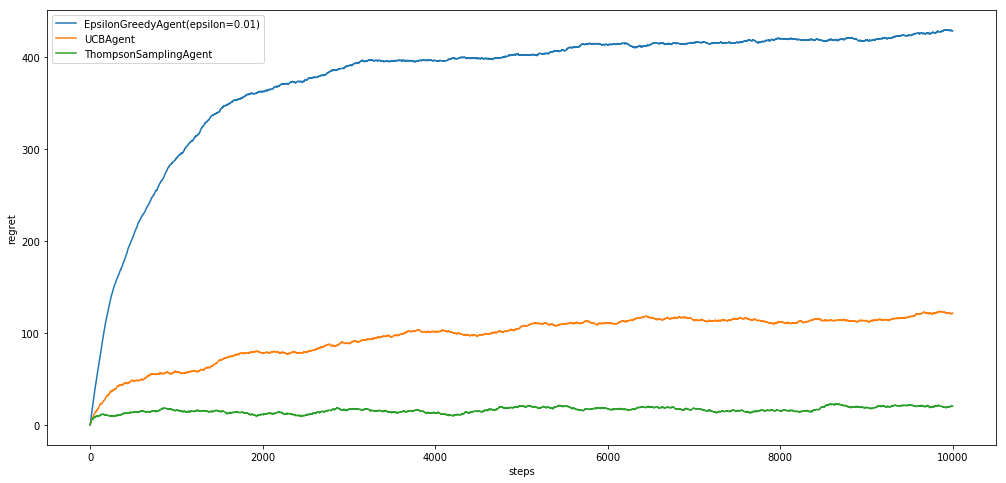

In [96]:
# Uncomment agents
agents = [
#     EpsilonGreedyAgent(),
#     UCBAgent(),
#     ThompsonSamplingAgent()
]

plot_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)

# Нестационарные байесовские бандиты

Что если вероятности успеха изменяются во времени? Например:

In [13]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        """
        Idea from https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)
        
        self._gamma = gamma
        
        self._successes = None
        self._failures = None
        self._steps = 0
        
        self.reset()
        
    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0
    
    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)
        
    def _step(self, action, reward): 
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

Посмотрим, как вероятности вознаграждений меняются во времени:

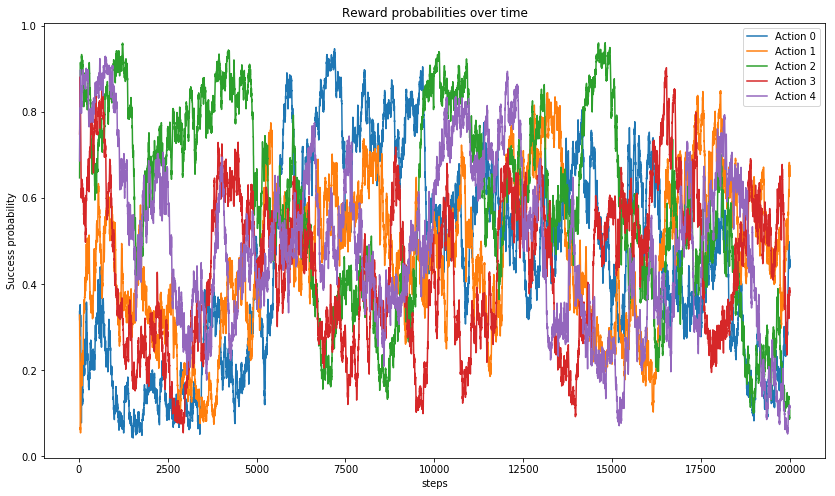

In [16]:
drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(14, 8))
plt.plot(pd.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

**Задача** - придумать агента, который будет работать лучше, чем стационарные агенты выше.

In [11]:
# YOUR AGENT GOES HERE

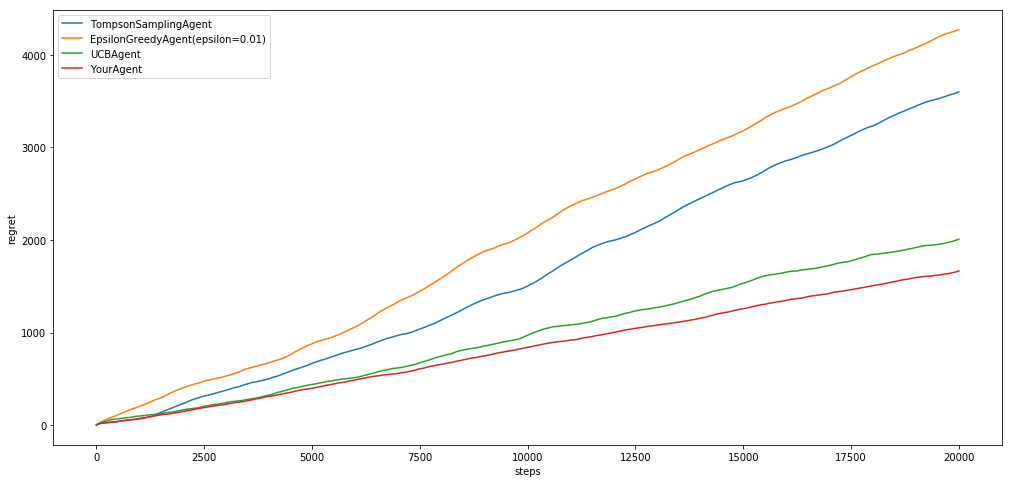

In [50]:
drifting_agents = [
    TompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
    YourAgent()
]
    
plot_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)

## Exploration в МППР

Следующая задача, "заплыв по реке", иллюстрирует важность exploration'а на примере марковских процессов принятия решений.

<img src="river_swim.png">

Иллюстрация из https://arxiv.org/abs/1306.0940

Вознаграждения и карты переходов агенту неизвестны. Оптимальная стратегия - плыть против течения, тогда как наиболее простой способ получить реворд - плыть налево.

In [26]:
class RiverSwimEnv:
    LEFT_REWARD = 5.0 / 1000
    RIGHT_REWARD = 1.0
    
    def __init__(self, intermediate_states_count=4, max_steps=16):
        self._max_steps = max_steps
        self._current_state = None
        self._steps = None
        self._interm_states = intermediate_states_count
        self.reset()
        
    def reset(self):
        self._steps = 0
        self._current_state = 1
        return self._current_state, 0.0, False
        
    @property
    def n_actions(self):
        return 2
    
    @property
    def n_states(self):
        return 2 + self._interm_states
    
    def _get_transition_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0, 1.0, 0]
            else:
                return [1.0, 0, 0]
            
        elif action == 1:
            if self._current_state == 0:
                return [0, .4, .6]
            if self._current_state == self.n_states - 1:
                return [.4, .6, 0]
            else:
                return [.05, .6, .35]
        else:
            raise RuntumeError("Unknown action {}. Max action is {}".format(action, self.n_actions))

    def step(self, action):
        """
        :param action:
        :type action: int
        :return: observation, reward, is_done
        :rtype: (int, float, bool)
        """
        reward = 0.0
        
        if self._steps >= self._max_steps:
            return self._current_state, reward, True
        
        transition = np.random.choice(range(3), p=self._get_transition_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1
        
        if self._current_state == 0:
            reward = self.LEFT_REWARD
        elif self._current_state == self.n_states - 1:
            reward = self.RIGHT_REWARD
        
        self._steps += 1
        return self._current_state, reward, False

Реализуем q-обучающегося агента с $\varepsilon$-greedy стратегией и посмотрим, насколько он хорошо здесь сработает.

In [28]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=0.2, gamma=0.95, epsilon=0.1):
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n_states, n_actions))
        self._lr = lr

    def get_action(self, state):
        if np.random.random() < self._epsilon:
            return np.random.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])
    
    def get_q_matrix(self):
        """ Used for policy visualization
        """
        
        return self._q_matrix
        
    def start_episode(self):
        """ Used in PSRL agent
        """
        pass

    def update(self, state, action, reward, next_state):
        ... # YOUR CODE GOES HERE

In [29]:
def train_mdp_agent(agent, env, n_episodes):
    episode_rewards = []
    
    for ep in range(n_episodes):
        state, ep_reward, is_done = env.reset()
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)
            
            next_state, reward, is_done = env.step(action)
            agent.update(state, action, reward, next_state)
            
            state = next_state
            ep_reward += reward
            
        episode_rewards.append(ep_reward)
    return episode_rewards

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


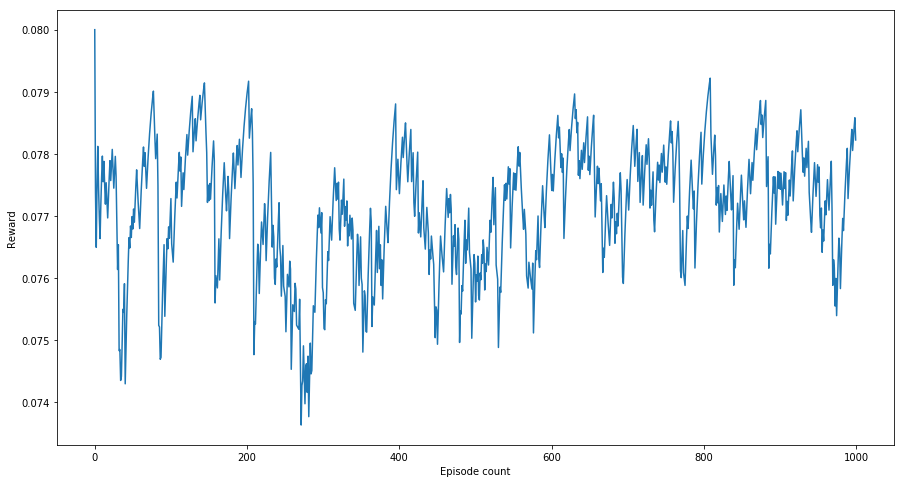

In [102]:
env = RiverSwimEnv()
agent = QLearningAgent(env.n_states, env.n_actions)
rews = train_mdp_agent(agent, env, 1000)
plt.figure(figsize=(15, 8))

plt.plot(pandas.ewma(np.array(rews),alpha=.1))
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

Реализуем стратегию принятия решений:

In [103]:
def plot_policy(agent):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.matshow(agent.get_q_matrix().T)
    ax.set_yticklabels(['', 'left', 'right'])
    plt.xlabel("State")
    plt.ylabel("Action")
    plt.title("Values of state-action pairs")
    plt.show()

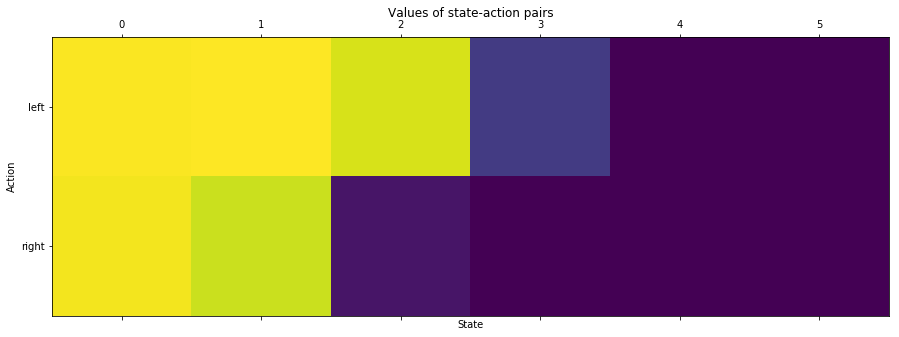

In [104]:
plot_policy(agent)

Можно видеть, что агент использует неоптимальную стратению и плывет налево, не узнавая про правое выигрышное состояние.

## Posterior sampling RL

Теперь реализуем Thompson Sampling для МППР!

Общий алгоритм:

>**for** episode $k = 1,2,...$ **do**
>> sample $M_k \sim f(\bullet\ |\ H_k)$

>> compute policy $\mu_k$ for $M_k$

>> **for** time $t = 1, 2,...$ **do**

>>> take action  $a_t$ from $\mu_k$ 

>>> observe $r_t$ and $s_{t+1}$
>>> update $H_k$

>> **end for**

>**end for**



В нашем случае $M_k$ моделируется двумя матрицами: переходов и вознаграждений. Матрица переходов сэмплируется из распределения Дирихле, тогда как матрица вознаграждений сэмплируется из гамма-нормального распределения.

Распределения обновляются по правилу Байеса, см. https://en.wikipedia.org/wiki/Conjugate_prior для непрерывных распределений.

Статья по теме - https://arxiv.org/abs/1306.0940.

In [105]:
def sample_normal_gamma(mu, lmbd, alpha, beta):
    """ https://en.wikipedia.org/wiki/Normal-gamma_distribution
    """
    tau = np.random.gamma(alpha, beta)
    mu = np.random.normal(mu , 1.0 / np.sqrt(lmbd * tau))
    return mu, tau

class PsrlAgent:
    def __init__(self, n_states, n_actions, horizon=10):
        self._n_states = n_states
        self._n_actions = n_actions
        self._horizon = horizon
        
        # params for transition sampling - Dirichlet distribution
        self._transition_counts = np.zeros((n_states, n_states, n_actions)) + 1.0
        
        # params for reward sampling - Normal-gamma distribution
        self._mu_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._state_action_counts = np.zeros((n_states, n_actions)) + 1.0  # lambda
        
        self._alpha_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._beta_matrix = np.zeros((n_states, n_actions)) + 1.0
        
        
    def _value_iteration(self, transitions, rewards):
        ... # YOUR CODE GOES HERE
        state_values = < Find action values with value iteration >
        return state_values
        
    def start_episode(self):
        # sample new  mdp
        self._sampled_transitions = np.apply_along_axis(np.random.dirichlet, 1, self._transition_counts)
        
        sampled_reward_mus, sampled_reward_stds = sample_normal_gamma(
            self._mu_matrix,
            self._state_action_counts,
            self._alpha_matrix,
            self._beta_matrix
        )
        

        self._sampled_rewards = sampled_reward_mus
        self._current_value_function = self._value_iteration(self._sampled_transitions, self._sampled_rewards)

    def get_action(self, state):
        return np.argmax(self._sampled_rewards[state] + 
                         self._current_value_function.dot(self._sampled_transitions[state]))

    def update(self, state, action, reward, next_state):
        ... # YOUR CODE GOES HERE
        # update rules - https://en.wikipedia.org/wiki/Conjugate_prior
        
    def get_q_matrix(self):
        return self._sampled_rewards + self._current_value_function.dot(self._sampled_transitions)
        

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  import sys


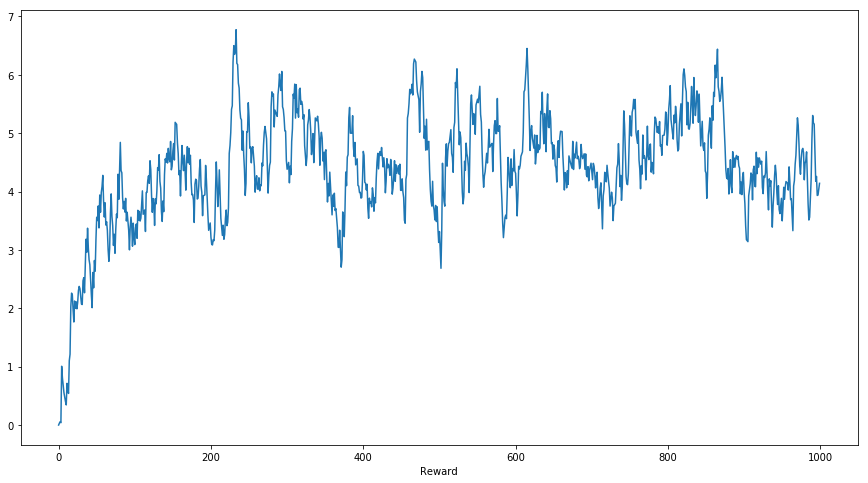

In [71]:
horizon = 20
env = RiverSwimEnv(max_steps=horizon)
agent = PsrlAgent(env.n_states, env.n_actions, horizon=horizon)
rews = train_mdp_agent(agent, env, 1000)

plt.figure(figsize=(15, 8))
plt.plot(pandas.ewma(np.array(rews), alpha=0.1))

plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

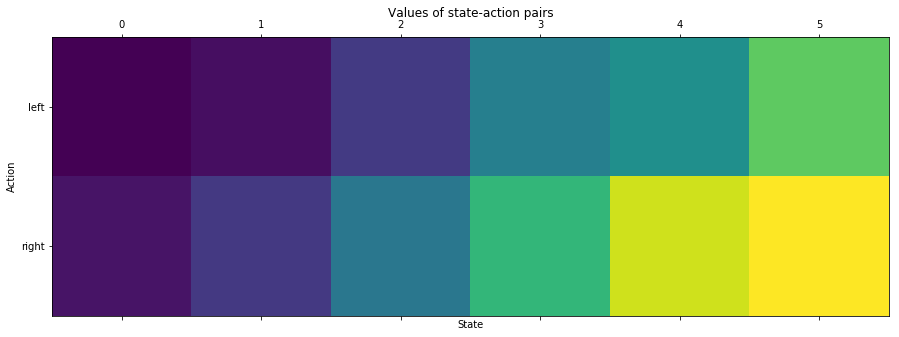

In [72]:
plot_policy(agent)